In [71]:
import pandas as pd 
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point

# Load stay point data
info = pd.read_csv(r"\\tsclient\D\Siyu Zhao\data\\Auckland region park\\infostop_with_specific_homelocation.csv")
info["geometry"] = info.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
stay_gdf = gpd.GeoDataFrame(info, geometry="geometry", crs="EPSG:4326").to_crs(epsg=3857)

# Load POIs
pois_path = Path(r"\\tsclient\D\Siyu Zhao\data\Auckland region park\Auckland-parks-poi.gpkg")
pois = gpd.read_file(pois_path).to_crs(epsg=3857)

# Spatial join: find nearest POI
matched_all = gpd.sjoin_nearest(
    stay_gdf, pois, how="left", distance_col="poi_distance", max_distance=None
)

# Assign stay_id for grouping
matched_all["stay_id"] = matched_all.index

# Flag POIs with name
matched_all["has_name"] = matched_all["name"].notna()

# Keep closest POI with name if available
matched_filtered = (
    matched_all.sort_values(["stay_id", "has_name", "poi_distance"], ascending=[True, False, True])
    .groupby("stay_id", as_index=False)
    .first()
)

print(matched_filtered.columns)

Index(['stay_id', 'stay_session_id', 'hashed_id', 'destination_id', 'start_ts',
       'end_ts', 'point_count', 'lat_left', 'lon_left', 'duration_minutes',
       'start_time', 'end_time', 'home_location_geom', 'home_x', 'home_y',
       'geometry', 'index_right', 'id', 'timestamp', 'visible', 'version',
       'tags', 'lon_right', 'changeset', 'lat_right', 'addr:city',
       'addr:housenumber', 'addr:housename', 'addr:postcode', 'addr:street',
       'email', 'name', 'opening_hours', 'operator', 'phone', 'ref', 'website',
       'tourism', 'zoo', 'leisure', 'outdoor_seating', 'natural', 'amenity',
       'bicycle_parking', 'fountain', 'internet_access', 'parking', 'source',
       'start_date', 'wikipedia', 'shop', 'historic', 'memorial', 'access',
       'foot', 'highway', 'lit', 'public_transport', 'railway', 'osm_type',
       'wetland', 'building', 'building:levels', 'drinking_water', 'area',
       'surface', 'aeroway', 'poi_distance', 'has_name'],
      dtype='object')


In [75]:


# Final output: all info columns + selected POI fields + distance
output_columns = [
    "hashed_id", "destination_id", "point_count", "lat_left", "lon_left", "duration_minutes",
    "start_time", "end_time", "home_location_geom", "home_x", "home_y",
    "geometry","amenity", "name", "leisure", "natural", "highway", "public_transport", "poi_distance"
]
matched_filtered = matched_filtered[output_columns]

print(len(matched_filtered) ) 
print(len(info) )
print(matched_filtered.columns)

70030
70030
Index(['hashed_id', 'destination_id', 'point_count', 'lat_left', 'lon_left',
       'duration_minutes', 'start_time', 'end_time', 'home_location_geom',
       'home_x', 'home_y', 'geometry', 'amenity', 'name', 'leisure', 'natural',
       'highway', 'public_transport', 'poi_distance'],
      dtype='object')


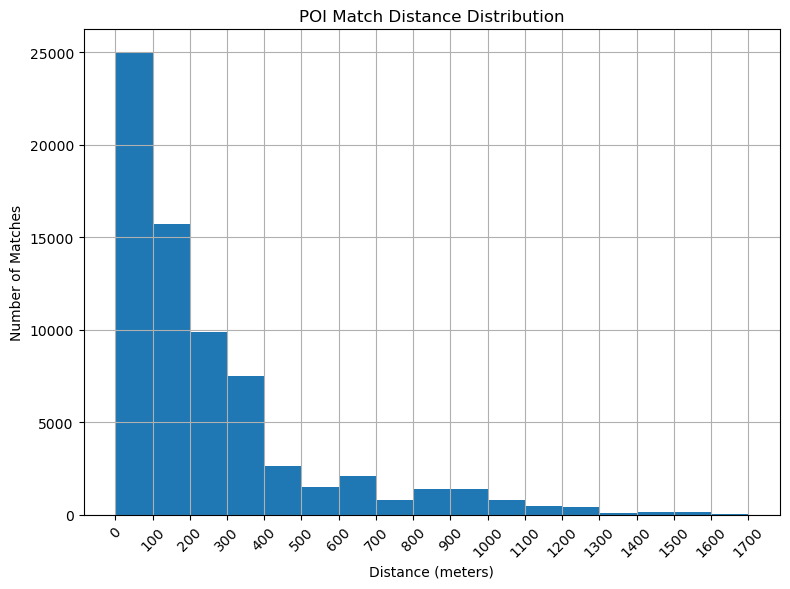

In [76]:
import matplotlib.pyplot as plt

max_dist = int(matched_filtered["poi_distance"].max()) + 100
bins = list(range(0, max_dist, 100))

plt.figure(figsize=(8, 6))
matched_filtered["poi_distance"].hist(bins=bins)
plt.title("POI Match Distance Distribution")
plt.xlabel("Distance (meters)")
plt.ylabel("Number of Matches")
plt.xticks(bins, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
print(pois.geometry.type.value_counts())

Polygon            887
Point              815
MultiPolygon         5
MultiLineString      3
LineString           1
Name: count, dtype: int64


In [77]:

matched = matched_filtered[matched_filtered["poi_distance"] <= 200].copy()

print(len(matched))

40720


In [78]:

# Calculate distance between home location and matched POI using x/y
matched = matched.dropna(subset=["home_x", "home_y"])
matched["poi_x"] = matched.geometry.x
matched["poi_y"] = matched.geometry.y

matched["home_poi_distance"] = np.sqrt(
    (matched["home_x"] - matched["poi_x"])**2 +
    (matched["home_y"] - matched["poi_y"])**2
)

print(matched[["poi_distance", "home_poi_distance"]].head())

   poi_distance  home_poi_distance
1     56.788335          21.449057
2     70.007215           2.886409
3     70.038479           2.018135
4     71.391451           6.000290
5     66.900439           5.085336


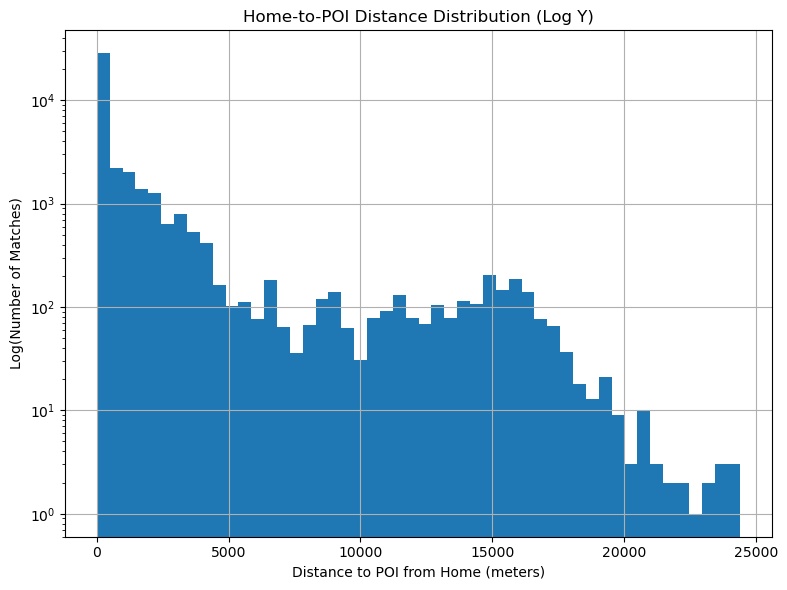

In [79]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(8, 6))
matched["home_poi_distance"].hist(bins=50)

plt.yscale("log")  # Apply logarithmic scale to Y-axis
plt.title("Home-to-POI Distance Distribution (Log Y)")
plt.xlabel("Distance to POI from Home (meters)")
plt.ylabel("Log(Number of Matches)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [80]:
matched.to_csv(r"\\tsclient\D\Siyu Zhao\data\Auckland region park\infostop_with_specific_homelocation_matched_poi.csv", index=False)
               

               

In [ ]:
import pandas as pd 
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point

# Load stay point data
info = pd.read_csv(r"\\tsclient\D\Siyu Zhao\data\\Auckland region park\\infostop_with_no_homelocation.csv")
info["geometry"] = info.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
stay_gdf = gpd.GeoDataFrame(info, geometry="geometry", crs="EPSG:4326").to_crs(epsg=3857)

# Load POIs
pois_path = Path(r"\\tsclient\D\Siyu Zhao\data\Auckland region park\Auckland-parks-poi.gpkg")
pois = gpd.read_file(pois_path).to_crs(epsg=3857)

# Spatial join: find nearest POI
matched_all = gpd.sjoin_nearest(
    stay_gdf, pois, how="left", distance_col="poi_distance", max_distance=None
)

# Assign stay_id for grouping
matched_all["stay_id"] = matched_all.index

# Flag POIs with name
matched_all["has_name"] = matched_all["name"].notna()

# Keep closest POI with name if available
matched_filtered = (
    matched_all.sort_values(["stay_id", "has_name", "poi_distance"], ascending=[True, False, True])
    .groupby("stay_id", as_index=False)
    .first()
)

# Final output: all info columns + selected POI fields + distance
output_columns = [
    "hashed_id", "destination_id", "point_count", "lat_left", "lon_left", "duration_minutes",
    "start_time", "end_time", 
    "geometry","amenity", "name", "leisure", "natural", "highway", "public_transport", "poi_distance"
]
matched_filtered = matched_filtered[output_columns]

print(len(matched_filtered) ) 
print(len(info) )
print(matched_filtered.columns)



30932
30932
Index(['hashed_id', 'destination_id', 'point_count', 'lat_left', 'lon_left',
       'duration_minutes', 'start_time', 'end_time', 'geometry', 'amenity',
       'name', 'leisure', 'natural', 'highway', 'public_transport',
       'poi_distance'],
      dtype='object')


In [83]:
print(matched_filtered["poi_distance"])

0          0.000000
1        202.024921
2          0.000000
3        209.420958
4          0.000000
            ...    
30927    257.032002
30928    269.509732
30929     92.780235
30930      0.000000
30931    137.272947
Name: poi_distance, Length: 30932, dtype: float64


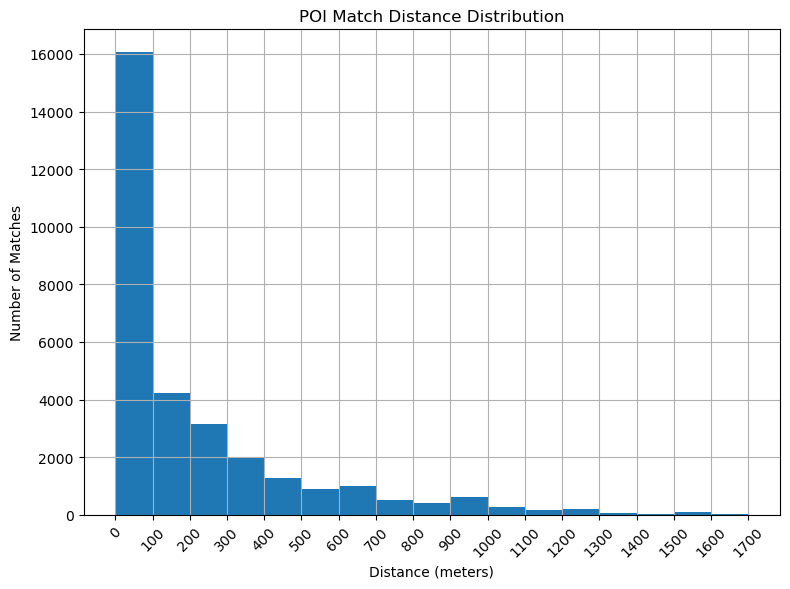

In [88]:
import matplotlib.pyplot as plt

max_dist = int(matched_filtered["poi_distance"].max()) + 100
bins = list(range(0, max_dist, 100))

plt.figure(figsize=(8, 6))
matched_filtered["poi_distance"].hist(bins=bins)
plt.title("POI Match Distance Distribution")
plt.xlabel("Distance (meters)")
plt.ylabel("Number of Matches")
plt.xticks(bins, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
matched_filtered = matched_filtered[matched_filtered["poi_distance"] <= 200].copy()

print(len(matched_filtered))

20265


In [91]:
print(matched_filtered["poi_distance"].head())

0     0.000000
2     0.000000
4     0.000000
5    95.451148
9     0.000000
Name: poi_distance, dtype: float64


In [92]:
matched_filtered.to_csv(r"\\tsclient\D\Siyu Zhao\data\Auckland region park\infostop_with_no_homelocation_matched_poi.csv", index=False)